### 合併商家數量(y)與捷運站人口結構資料

In [1]:
%matplotlib inline
#%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Microsoft JhengHei']# 指定中文字型
# plt.rcParams['axes.unicode_minus']=False   # 用来正常显示负号
plt.style.use('seaborn-whitegrid')

import seaborn as sns
sns.set_theme(color_codes=True)

#### 讀取所有資料及整理

In [2]:
# 讀取所有資料
path= '../data/'
file= 'all_data_final_v4_20210110.csv'
df = pd.read_csv( path+file ,encoding='utf-8')

print(df.columns,'\n')

# 檢視不同營運狀態的站點數量 。1: 有運量資歷的站點、 10: 缺乏運量資料的站點(淡水輕軌)、0: 規劃中站點
print(df.groupby('Activated').size(),'\n')   



# 填補缺值。 !!!  注意目前主要流量料有缺值，另外租金資料為0的本身也是缺值
# df.fillna(value=0, inplace=True)
# print(df.isnull().any())

# 取出租金非0的資料
inex = df[df['Median_Rent'].notnull()].index

# 指定選取站點。 
# data = df.query('Activated == 1 ')   # 'Activated'型態為數值資料
data =  df.loc[inex,:]
# print(data.groupby('Activated').size(),'\n') 

# print(data.isnull().any())  # 檢視缺值

Index(['Station_Type', 'Activated', 'Station_ID', 'Station_Name', 'T_Status',
       'Num_Transfer', 'Num_Atm', 'Num_Cstore', 'Num_Med', 'Num_Ele',
       'Num_Sec', 'Num_High', 'All_School', 'Num_POI', 'Num_Park',
       'Num_Village', 'Income_Gross', 'Income_Average', 'Population', 'Child',
       'Adult', 'Old_Age', 'Young_Adult', 'Middle_Age', 'Child_Dep', 'Old_Dep',
       'Higher_Edu', 'Sec_Edu', 'Ele_Edu', 'Uneducated', 'Male', 'Married',
       'Immigrant', 'Birth', 'Vol_All', 'Vol_Workday', 'Weekend',
       'Median_Rent', 'Num_Cafe', 'Num_Drink', 'Num_Bar', 'Num_Gym',
       'Num_Lodging', 'Cat_Vol', 'Cat_Rent', 'Cat_Cafe', 'Cat_Drink',
       'Cat_Bar', 'Cat_Gym', 'Cat_Lodging'],
      dtype='object') 

Activated
0     105
1     173
10     14
dtype: int64 



In [3]:
# data.loc[:,:'Birth'].describe()

In [4]:
# data.loc[:,'Vol_All':].describe()

# 評估模型測試
0. 將所有特徵值做相關性矩陣分析(VS 正規化前後)
1. 先使用分類樹的回歸模型幫忙判別重要特徵值
2. 使用Cross Validation 測試所有迴歸模型 (線性迴歸、隨機森林、支持向量機、GB)
3. 以評分(RMSE 或R^2)篩選出效率較好的模型
4. 針對該模型以網格搜尋進行參數微調

### 1. 特徵選擇

- https://machinelearningmastery.com/calculate-feature-importance-with-python/https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [5]:
# 用來找出特徵值的函式  
'''輸入rmse的分數，回傳: 
   1. 重要特徵值的解釋力佔比(隨機森林回歸) 或
   2. 係數值(Lasso迴歸) 
'''
def feature_import(feature_score):
    feature_names =list(X.columns.values)  # 取得變數名稱
    feature_importances = {}               # 取得變數評分值 
    for var , score in zip(feature_names, feature_score):
        feature_importances.update( {var : score } )
#     print(f'{score:.3f} : {var} ')

    # 將特徵重要性依大小排序
    feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))  # 按value排序
    df = pd.DataFrame.from_dict(feature_importances,orient='index', columns=['socre'])
    
    if df['socre'].sum() <= 1.1:                 # 擷取隨機森林迴歸的重要值(所有權種合計為1)   
#         return df.head(10)                        # 傳回表 
        return  df.head(10).plot(kind="bar")   # 傳回圖

    else:
        df_coff = df[(df.values > 1)
                | (df.values < -1)]     # 擷取lasso迴歸的重要係數
#         return df_coff                   # 傳回表  
        return  df_coff.plot(kind="bar")   # 傳回圖
                    
# 用來顯示績效評分的的函式
def display_scores(scores):
    print(f'Scores:\n{scores}')
    print(f'Mean  :{scores.mean():.3f}')
    print(f'S.d.  :{scores.std():.3f}')

In [6]:
print(data.columns)

Index(['Station_Type', 'Activated', 'Station_ID', 'Station_Name', 'T_Status',
       'Num_Transfer', 'Num_Atm', 'Num_Cstore', 'Num_Med', 'Num_Ele',
       'Num_Sec', 'Num_High', 'All_School', 'Num_POI', 'Num_Park',
       'Num_Village', 'Income_Gross', 'Income_Average', 'Population', 'Child',
       'Adult', 'Old_Age', 'Young_Adult', 'Middle_Age', 'Child_Dep', 'Old_Dep',
       'Higher_Edu', 'Sec_Edu', 'Ele_Edu', 'Uneducated', 'Male', 'Married',
       'Immigrant', 'Birth', 'Vol_All', 'Vol_Workday', 'Weekend',
       'Median_Rent', 'Num_Cafe', 'Num_Drink', 'Num_Bar', 'Num_Gym',
       'Num_Lodging', 'Cat_Vol', 'Cat_Rent', 'Cat_Cafe', 'Cat_Drink',
       'Cat_Bar', 'Cat_Gym', 'Cat_Lodging'],
      dtype='object')


### 資料集準備

In [7]:
# 資料集準備
from sklearn import preprocessing

# 在這邊手動設定預測項目
y = data['Median_Rent']

feature_selected = [
                    'Num_Atm', 'Num_Cstore', 'Num_Med', 'Num_Ele',
                    'Num_Sec', 'Num_High','Num_POI', 'Num_Park',
                    'Income_Gross', 'Income_Average', 'Population', 'Child',
                    'Old_Age', 'Young_Adult', 'Middle_Age', 'Child_Dep', 'Old_Dep',
                    'Higher_Edu', 'Sec_Edu', 'Ele_Edu', 'Uneducated', 'Male', 'Married',
                    'Immigrant', 'Birth'
                    ] 
X = data[feature_selected]

# print(X.dtypes)

# 採用label encoder 將類別資料轉為數值型態
# label_encoder = preprocessing.LabelEncoder()
# encoded_S_Type = label_encoder.fit_transform(X['Station_Type'])
# X.loc[:,'Station_Type'] = encoded_S_Type.copy()



### 2. 選擇與訓練模型
- 使用Cross Validation 進行模型績效比較

In [8]:
# # 根據特徵重新挑選特徵值  


# from sklearn import preprocessing

# feature_selected = ['Income_Gross', 
#                     'Vol_All','Weekend',
#                     'Num_Atm','Num_Med','Num_Cstore','Immigrant','Num_Ele','Num_POI'
#                     ] 

# X = data[feature_selected]

# print(X.dtypes)

# # 採用label encoder 將類別資料轉為數值型態
# # label_encoder = preprocessing.LabelEncoder()
# # encoded_S_Type = label_encoder.fit_transform(X['Station_Type'])
# # X.loc[:,'Station_Type'] = encoded_S_Type.copy()



### Lasso


Scores:
[0.62242564 0.64137333 0.64549786 0.46419958 0.66041183]
Mean  :0.607
S.d.  :0.072


測試集的rmse : 341.187
R^2 : 0.756


<AxesSubplot:>

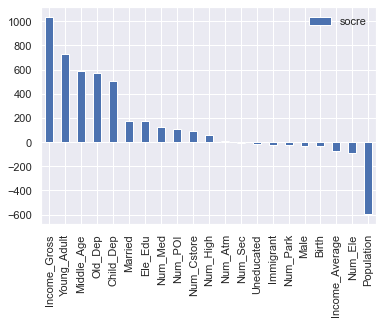

In [9]:
# Lasso模型
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,r2_score
 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

model = Lasso(max_iter=10**4)
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

# Cross Validation 
Lasso_scores = cross_val_score(model, X_train, y_train,
         scoring='r2',cv=5 )
# Lasso_scores = np.sqrt(-scores)

display_scores(Lasso_scores)

print('\n')
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'測試集的rmse : {rmse:.3f}') 

r2 = r2_score(y_test, y_pred)
print(f'R^2 : {r2:.3f}' )

# 檢視特徵重要性
feature_score = model.coef_
feature_import(feature_score)

### RandomForest

Scores:
[0.66356104 0.55300584 0.64522965 0.4977885  0.67021484]
Mean  :0.606
S.d.  :0.069


測試集的rmse : 369.870
R^2 : 0.713


<AxesSubplot:>

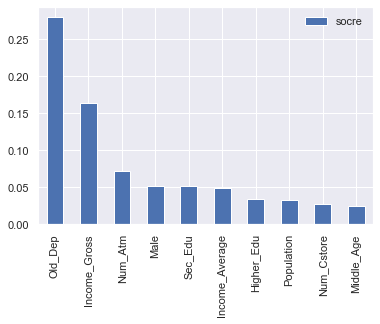

In [10]:
 # 隨機森林迴歸分類器 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  mean_squared_error,r2_score
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# max_depth=5, n_estimators=100
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)


# Cross Validation
forest_scores = cross_val_score(model, X_train, y_train,
         scoring='r2',cv=5 )
# forest_scores = np.sqrt(-scores)

display_scores(forest_scores)

print('\n')

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'測試集的rmse : {rmse:.3f}') 

r2 = r2_score(y_test, y_pred)
print(f'R^2 : {r2:.3f}' )

# 檢視特徵重要性
feature_score = model.feature_importances_
feature_import(feature_score)

### SVM

In [11]:
# SVM
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error,r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# we can change kernel to rbf, poly, linear
model = SVR(kernel='linear')
# svm_reg = SVC(kernel='linear')
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)


# Cross Validation
svr_scores = cross_val_score(model, X_train, y_train, 
         scoring='r2',cv=5 )
# svr_scores = np.sqrt(-scores)
display_scores(svr_scores)

print('\n')

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'測試集的rmse : {rmse:.3f}') 

r2 = r2_score(y_test, y_pred)
print(f'R^2 : {r2:.3f}' )

Scores:
[0.45020604 0.46824996 0.36049078 0.73295592 0.48411054]
Mean  :0.499
S.d.  :0.124


測試集的rmse : 353.223
R^2 : 0.738


### GradientBoostingRegressor

Scores:
[0.59312782 0.52231753 0.6796026  0.45011127 0.48205746]
Mean  :0.545
S.d.  :0.082


測試集的rmse : 391.379
R^2 : 0.679


<AxesSubplot:>

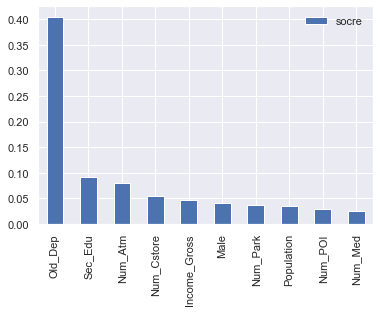

In [12]:
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error,r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)


# Cross Validation
gbrt_scores = cross_val_score(model, X_train, y_train,
         scoring='r2',cv=5 )
# gbrt_scores = np.sqrt(-scores)

display_scores(gbrt_scores)

print('\n')

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'測試集的rmse : {rmse:.3f}') 

r2 = r2_score(y_test, y_pred)
print(f'R^2 : {r2:.3f}' )

# 檢視特徵重要性
feature_score = model.feature_importances_
feature_import(feature_score)

### 作圖比較各模型在Cross Validation後的rmse得分均值與標準差

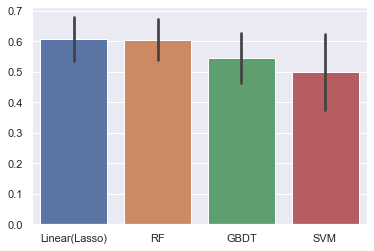

In [13]:
# sns.barplot( ci="sd")
# sns.barplot(x="day", y="tip", data=tips, estimator=median)
from numpy import median,mean
# sns.set_theme(style="whitegrid")

data = {'Linear(Lasso)' :Lasso_scores,
        'RF' :forest_scores,
        'GBDT':gbrt_scores,
        'SVM' :svr_scores }

df_CV =pd.DataFrame(data)

ax = sns.barplot(data=df_CV, estimator=mean, ci="sd",   )
# y ='RMSE_Score'


### 微調模型
- 隨機搜尋

#### 以隨機搜尋尋找最佳參數

0.6674480536502023 {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 870}
0.6156262070389623 {'max_depth': 15, 'max_features': 'auto', 'n_estimators': 81}
0.668716715949781 {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 476}
0.6014754328072349 {'max_depth': 11, 'max_features': 'auto', 'n_estimators': 97}
0.651720803507076 {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 673}
0.6252931277009185 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 318}
0.5877536231801124 {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 501}
0.6582282395149424 {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 201}
0.5011106953393871 {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 323}
0.6194224000726755 {'max_depth': 12, 'max_features': 'auto', 'n_estimators': 570}
0.6711690437044492 {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 485}
0.6113327770946719 {'max_depth': 16, 'max_features': 'auto', 'n_estimators': 199}
0.6685132535358311 {'max_de

<AxesSubplot:>

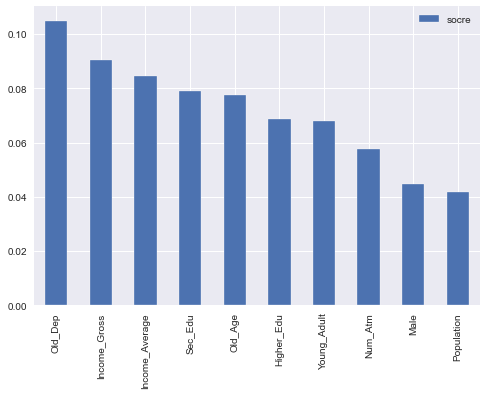

In [26]:
# RandomForestRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import  mean_squared_error,r2_score
from scipy.stats import randint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

param_distribs = {
    'n_estimators': randint(low=10, high=1000),
    'max_features': ['auto', 'sqrt'],
    'max_depth': randint(low=1, high=20),
    }

forest_reg = RandomForestRegressor(n_jobs=-1,random_state = 42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=30, cv=5, scoring='r2',n_jobs=-1, random_state=42)
rnd_search.fit(X_train, y_train)

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

# 檢視最佳參數
print(rnd_search.best_estimator_)

# 檢視特徵重要性
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_score = feature_importances
feature_import(feature_score)

In [27]:
# 產出最佳模型
final_model = rnd_search.best_estimator_
X_test = scaler.transform(X_test)
y_pred = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)
print(f'RMSE: {final_rmse:.3f}')

r2 = r2_score(y_test, y_pred)
print(f'R^2 : {r2:.3f}' )

RMSE: 335.202
R^2 : 0.764


### Model persistence using joblib

In [28]:
# my_model = final_model
# import joblib
# joblib.dump(my_model, "rent_model.pkl") # DIFF
# #...
# my_model_loaded = joblib.load("rent_model.pkl") # DIFF

### 繪製學習曲線

Training sizes: [ 23  77 130 184 238] 

Training scores:
  [[-246.10445559 -195.56931096 -195.56931096 -195.56931096 -195.56931096
  -195.56931096 -195.56931096 -195.56931096 -195.56931096 -195.56931096]
 [-203.60327068 -174.64176222 -216.75634151 -233.19295688 -233.19295688
  -233.19295688 -233.19295688 -233.19295688 -233.19295688 -233.19295688]
 [-171.38402311 -160.40938886 -177.23212308 -185.68532959 -181.00367196
  -186.38966861 -186.38966861 -186.38966861 -186.38966861 -186.38966861]
 [-154.850921   -141.94256482 -160.29025551 -162.53063768 -171.00902572
  -166.01841165 -166.75274418 -165.40784832 -165.40784832 -165.40784832]
 [-146.68663983 -137.50204889 -152.41162734 -153.81643879 -160.49382698
  -157.70035709 -156.25839848 -157.27863237 -159.8145548  -150.62195184]] 


Test scores:
 [[-612.53571385 -777.04939846 -672.54507877 -310.14316767 -686.10035791
  -313.6037189  -508.95878373 -753.93828101 -796.17055718 -626.7581533 ]
 [-632.20306767 -755.70697984 -571.31146248 -326.7846

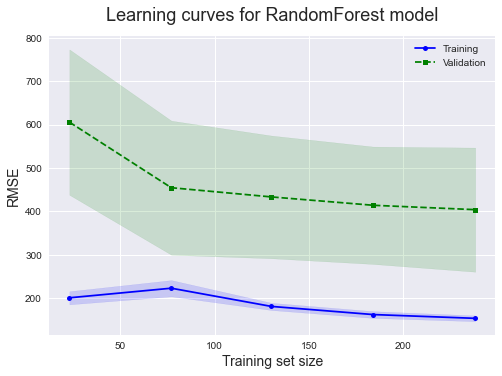

In [41]:
from sklearn.model_selection import learning_curve
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

train_sizes, train_scores, test_scores = learning_curve(
    estimator = final_model, X=X, y=y, 
    train_sizes= np.linspace(0.1, 1.0, 5), 
    scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)

print('Training sizes:',train_sizes, '\n') 
print('Training scores:\n ',train_scores, '\n')
print('\nTest scores:\n',test_scores, '\n')
print( '-' * 70)

train_scores_mean = train_scores.mean(axis = 1)
test_scores_mean = test_scores.mean(axis = 1 )
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(test_scores_mean, index = train_sizes))

# 繪圖
import matplotlib.pyplot as plt
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.style.use('seaborn')

plt.plot(train_sizes, train_mean, color='blue' ,marker='o' ,markersize=5, label = 'Training')
plt.fill_between(train_sizes,
                train_mean+train_std,
                train_mean-train_std,
                alpha=0.15,color='blue'
                )
plt.plot(train_sizes, test_mean, color='green' ,marker='s' ,markersize=5, linestyle='--',  label = 'Validation')

plt.fill_between(train_sizes,
                test_mean+test_std,
                test_mean-test_std,
                alpha=0.15,color='green' 
                )

plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for RandomForest model', fontsize = 18, y = 1.03)
plt.legend(loc='upper right')
# plt.ylim(0,1.1)

## 用訓練出的模型取出預測值

### 取出測試資料預測的y值

In [31]:
# 取出預測的y值， 注意這邊取得的預測值是最後跑的那個model

y_pred = pd.DataFrame( y_pred.reshape(-1,1).round(3), index=y_test.index, columns=['Prediction'])

dataset = [df['Station_Name'], pd.DataFrame(y_test), y_pred ] 

df_y_pred = pd.concat(dataset, join='inner' , axis=1)

# df_y_pred['P_Store'] = (df_y_pred['Prediction'] - df_y_pred[y.name]) 
# df_y_pred['Potential'] = (df_y_pred['Prediction'] - df_y_pred[y.name])/df_y_pred['Prediction']*100

df_y_pred 

,Station_Name,Median_Rent,Prediction
6,板橋站,1562.0,1350.155
9,龍山寺站,1400.0,1613.545
10,善導寺站,2400.0,3220.551
15,後山埤站,1575.0,2279.748
16,昆陽站,1461.0,1513.036
20,萬芳社區站,1345.0,1356.822
25,科技大樓站,2445.0,2727.387
26,忠孝復興站,4000.0,3506.956
31,劍南路站,1936.0,1858.195
34,文德站,1600.0,1534.726


In [32]:
df_y_pred.describe()

,Median_Rent,Prediction
count,53.000000,53.000000
mean,1324.358491,1501.184472
std,697.170575,743.909148
min,428.000000,664.225000
25%,872.000000,1003.552000
50%,1103.000000,1207.365000
75%,1575.000000,1856.305000
max,4000.000000,3506.956000


### 將模型套用在未營運的站點 取得預測值

In [33]:
from sklearn import preprocessing


def get_pred_data():

    df  = pd.read_csv( path+file ,encoding='utf-8')
 
    model = final_model
    
    X = df[feature_selected]

    # 採用label encoder 將類別資料轉為數值型態
#     label_encoder = preprocessing.LabelEncoder()
#     encoded_S_Type = label_encoder.fit_transform(X['Station_Type'])
#     X.loc[:,'Station_Type'] = encoded_S_Type.copy()

    #正規化
    X = scaler.transform(X)

    # 設定要使用的模型， 注意這邊使用的model是最後跑的那個
    y = model.predict(X)

    y = pd.DataFrame(y.reshape(-1,1).round(0), index=df.index, columns=['Median_Rent_Pre'])  #取整數

    dataset = [df, y ] 

    df_pred = pd.concat(dataset, join='inner' , axis=1)
    
    #     將轉乘數量從LOG(base=e)轉換回去
    import math
    df_pred['Num_Transfer'] = (math.e)**(df_pred['Num_Transfer'])
        
    return df_pred

get_pred_data()

,Station_Type,Activated,Station_ID,Station_Name,T_Status,Num_Transfer,Num_Atm,Num_Cstore,Num_Med,Num_Ele,...,Num_Gym,Num_Lodging,Cat_Vol,Cat_Rent,Cat_Cafe,Cat_Drink,Cat_Bar,Cat_Gym,Cat_Lodging,Median_Rent_Pre
0,TpMrt,1,BL01,頂埔站,N,1.0,13,6,6,5,...,3.0,0.0,6.0,2,0,0,0,0,0,1153.0
1,TpMrt,1,BL02,永寧站,N,1.0,11,5,1,9,...,0.0,0.0,7.0,1,0,0,0,0,0,938.0
2,TpMrt,1,BL03,土城站,N,1.0,22,10,28,7,...,4.0,1.0,6.0,2,0,0,0,1,0,1443.0
3,TpMrt,1,BL04,海山站,N,1.0,40,22,41,26,...,6.0,0.0,7.0,2,0,0,0,1,0,1216.0
4,TpMrt,1,BL05,亞東醫院站,N,1.0,19,8,9,18,...,1.0,0.0,8.0,1,0,0,0,0,0,1110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,Train,1,1100,中壢站,N,1.0,48,20,84,17,...,6.0,6.0,8.0,2,2,0,3,1,0,1163.0
288,Train,1,1110,埔心站,N,1.0,11,7,17,8,...,1.0,0.0,6.0,1,0,1,0,0,0,702.0
289,Train,1,1120,楊梅站,N,1.0,17,7,25,16,...,2.0,1.0,6.0,1,0,2,0,0,0,854.0
290,Train,1,1130,富岡站,N,1.0,5,3,1,3,...,0.0,0.0,5.0,1,0,0,0,0,0,952.0


In [34]:
import sys,os,time

# Where to save the data
PROJECT_ROOT_DIR = "../"
dir_name = "prediction_result/"
DATA_PATH = os.path.join(PROJECT_ROOT_DIR,dir_name)
os.makedirs(DATA_PATH, exist_ok=True)

def save_data(file_name):
    df = get_pred_data().copy()
    df.to_csv( DATA_PATH + file_name ,encoding='utf-8')
    print("Saving DATA:", file_name)

time =time.strftime("%y%m%d_%H%M")
save_data(f'Median_Rent_Pre_{time}.csv')


Saving DATA: Median_Rent_Pre_210123_1507.csv


In [35]:
df_pred = get_pred_data()
df_pred[['Median_Rent','Median_Rent_Pre']].describe()

,Median_Rent,Median_Rent_Pre
count,265.000000,292.000000
mean,1365.550943,1365.027397
std,745.410822,672.887939
min,367.000000,480.000000
25%,900.000000,930.000000
50%,1201.000000,1180.500000
75%,1562.000000,1545.750000
max,5000.000000,4166.000000


<AxesSubplot:ylabel='Frequency'>

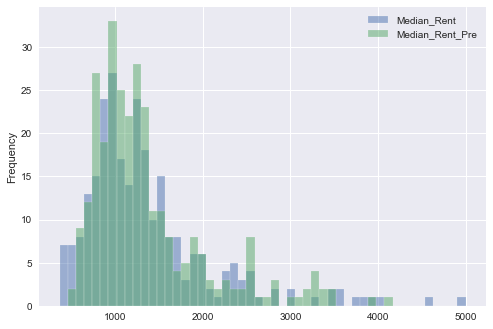

In [36]:
df_pred[['Median_Rent','Median_Rent_Pre']].plot.hist(alpha=0.5,bins=50)